# Debut

In [1]:
from jax import random, jit, vmap
import os
path = os.getcwd()
print("Old path:", path)
path = (path.split('/'))
path = path[:path.index("ABC-SBI")+1]
path = '/'.join(path)
print("New path:", path)
os.chdir(path)
from functions.simulation import get_dataset, ABC_epsilon, get_epsilon_star
from functions.training import train_loop
from functions.SBC import SBC_epsilon, plot_SBC, find_grid_explorative, post_pdf_z,post_sample, new_post_pdf_z
import jax.numpy as jnp
import time
import pickle 
import lzma
from jax.scipy.stats import norm, gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sbibm.metrics import c2st
import torch
from tqdm.notebook import tqdm
@jit
def prior_simulator(key):
    return random.normal(key, (1,))*SIGMA0 + MU0

@jit
def data_simulator(key, theta):
    return (random.normal(key, (N_DATA,))*SIGMA + theta).astype(float)

@jit
def discrepancy(y, y_true):
    return (jnp.mean(y) - jnp.mean(y_true))**2

def true_post(z):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * np.sum(z))/(SIGMA0**2*len(z) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(z)/SIGMA**2)
    return stats.norm(loc = mu_post, scale = np.sqrt(sigma2_post))


Old path: /Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss
New path: /Users/antoineluciano/Documents/Recherche/ABC-SBI


/Users/antoineluciano/.pyenv/versions/3.10.13/envs/jax_env/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [6]:
for i in range(10):
    key = random.PRNGKey(i)
    print(i, np.max(random.normal(key, (10,))))
# Define the simulation parameters

0 0.73168886
1 1.70968
2 1.0190237
3 1.7010686
4 0.91044223
5 1.9665504
6 1.2852666
7 0.9728025
8 0.6458293
9 2.4111242


In [ ]:
from functions.SBC import logratio_z, logratio_batch_z, post_pdf_z, find_grid_explorative
def true_post(z):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * np.sum(z))/(SIGMA0**2*len(z) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(z)/SIGMA**2)
    return stats.norm(loc = mu_post, scale = np.sqrt(sigma2_post))

def true_ratio_z(mus, z, prior, posterior):
    return posterior(z).pdf(mus)/prior.pdf(mus)

def true_decision_z(mus, z, prior, posterior):
    return 1/(1+1/true_ratio_z(mus, z, prior, posterior))

def true_pseudo_ratio_z(mus, z, bar_xobs, epsilon, prior, posterior):
    pseudo = true_pseudo_post(mus, bar_xobs, epsilon, prior)
    Z_pseudo = np.trapz(pseudo, mus)
    return posterior(z).pdf(mus)/pseudo*Z_pseudo

def true_pseudo_decision_z(mus, z, bar_xobs, epsilon, prior, posterior):
    return 1/(1+1/true_pseudo_ratio_z(mus, z, bar_xobs, epsilon, prior, posterior))

def true_pseudo_post(mus, bar_xobs, epsilon, prior):
    return prior.pdf(mus)*(norm.cdf(bar_xobs+np.sqrt(epsilon), loc = mus, scale = SIGMA/np.sqrt(N_DATA)) - norm.cdf(bar_xobs-np.sqrt(epsilon), loc = mus, scale = SIGMA/np.sqrt(N_DATA)))

def true_pseudo_decision_z(mus, z, bar_xobs, epsilon, prior, posterior):
    return 1/(1+1/true_pseudo_ratio_z(mus, z, bar_xobs, epsilon, prior, posterior))

def decision_z(params, mus, z):
    return 1/(1+jnp.exp(-logratio_z(params, mus, z)))
def decision_batch_z(params, mus, z):
    return 1/(1+jnp.exp(-logratio_batch_z(params, mus, z)))

def ABC_gauss_single(key, true_data, epsilon):
    key, key_xbar = random.split(key)
    xbar = random.truncated_normal(key_xbar, lower = (jnp.mean(true_data)-jnp.sqrt(epsilon)-MU0)/jnp.sqrt(SIGMA0**2+SIGMA**2/len(true_data)), upper = (jnp.mean(true_data)+jnp.sqrt(epsilon)-MU0)/jnp.sqrt(SIGMA0**2+SIGMA**2/len(true_data)))*jnp.sqrt(SIGMA0**2+SIGMA**2/len(true_data)) + MU0
    dist = (jnp.mean(true_data)-xbar)**2
    key, key_z = random.split(key)
    z = random.normal(key_z, (len(true_data),))*SIGMA
    z = z-jnp.mean(z)+xbar
    key, key_mu = random.split(key)
    mu = random.normal(key_mu, (1,))*SIGMA/jnp.sqrt(len(true_data)) + xbar
    return z, mu, dist


def ABC_gauss(key, true_data, epsilon, N_ABC):
    keys = random.split(key, N_ABC+1)
    zs, mus, dists = vmap(jit(ABC_gauss_single), (0, None, None))(keys[1:], true_data, epsilon)
    return zs, mus, dists, keys[0]

def get_epsilon_star_gauss(key, acceptance_rate, n_points, prior_simulator, data_simulator, discrepancy, true_data, quantile_rate = .9, epsilon = jnp.inf, return_accept = False):
    new_epsilon = epsilon
    accept = 1.
    
    datas, thetas, dists, key = ABC_gauss(key, true_data, epsilon, n_points)
    if epsilon == jnp.inf:
        print("Distances: min = ", jnp.min(dists), "max = ", jnp.max(dists), "mean = ", jnp.mean(dists), "std = ", jnp.std(dists))
    while accept > acceptance_rate:
        epsilon = new_epsilon
        new_epsilon = float(jnp.quantile(dists, quantile_rate))
        datas, thetas, dists, key = ABC_gauss(key, true_data, new_epsilon, n_points)
        key, subkey = random.split(key)
        keys_pred = random.split(subkey, n_points)
        datas_pred = vmap(data_simulator, in_axes=(0, 0))(keys_pred, thetas)
        new_dists = vmap(discrepancy, in_axes=(0, None))(datas_pred, true_data)
        accept = jnp.mean(new_dists < new_epsilon)
        epsilon = new_epsilon
        print("epsilon: ", epsilon, "acceptance rate: ", accept)
    if return_accept: 
        return epsilon, accept, key
    return epsilon, key

def get_dataset_gauss(key, n_points, prior_simulator, data_simulator, discrepancy, epsilon, true_data):
    n_points = n_points//2
    zs, thetas, _, key = ABC_gauss(key, true_data, epsilon, n_points)
    key, key_perm = random.split(key)
    thetas_prime = thetas[random.permutation(key_perm, jnp.arange(n_points))]
    zs = jnp.concatenate([zs, zs], axis=0)
    thetas = jnp.concatenate([thetas, thetas_prime], axis=0)
    ys = jnp.append(jnp.zeros(n_points), jnp.ones(n_points)).astype(int)
    Xs = jnp.concatenate([thetas, zs], axis=1)
    return Xs, ys, key


The standard NRE output is the ratio:
$$\hat r(x\mid \theta) \approx r(x\mid \theta) = \frac{f(x\mid\theta)}{p(x)} = \frac{\pi(\theta\mid x)}{\pi(\theta)}$$

The posterior approximation is then 
$$\hat \pi(\theta\mid x) \propto \pi(\theta) \cdot\hat r(x\mid \theta)$$

Here we train the NRE classifier with datas from the ABC joint pseudo posterior $\pi_\epsilon(\theta,x\mid x_o)$ with $\epsilon \in ] 0 , + \infty [$.

The ABC-NRE output is then:
$$\hat r_\epsilon(x\mid \theta, x_o) \approx r_\epsilon(x\mid \theta, x_o) =  \frac{\pi(\theta\mid x)}{\pi_\epsilon(\theta\mid x_o)}$$

and the posterior approximation becomes : 

$$\hat \pi(\theta\mid x, x_o) \propto \hat \pi_\epsilon(\theta\mid x_o) \cdot \hat r_\epsilon(x\mid \theta, x_o)$$

where $ \hat \pi_\epsilon(\theta\mid x_o) $ is a KDE approximation of the ABC pseudo posterior that plays the role of the ABC correction. 


Here we compare: 
- the ABC-NRE approximation with the KDE correction: $\hat \pi(\theta\mid x, x_o) \propto \hat \pi_\epsilon(\theta\mid x_o) \cdot \hat r_\epsilon(x\mid \theta, x_o)$.
- the ABC-NRE approximation without the KDE correction: $\hat \pi(\theta\mid x, x_o) \propto \pi(\theta) \cdot r_\epsilon(x\mid \theta, x_o)$. 
- the ABC pseudo posterior: $\pi_\epsilon(\theta\mid x_o)$
- the true posterior: $\pi(\theta\mid x_o)$.

Here we consider the Gaussian toy model 
$$\mu \sim \mathcal N(0, 10^2) \quad x = (x_1, \cdots, x_n) \sim \mathcal N(\mu, 1)$$

Even with $n = 10$, we remark that $r_\epsilon (x \mid \theta, x_o) >> \pi_\epsilon(\theta\mid x_o) \approx \pi(\theta)$ so there is no the correction does not change the posterior approximation. 

When $\epsilon$ is too small, $r_\epsilon(x\mid \theta, x_o) \propto 1$ and $\pi_\epsilon(\theta\mid x_o) \approx \pi(\theta\mid x_o)$. The NRE approximation without the correction is then the prior and becomes close to the posterior with the ABC correction. 


# Data simulation ($x_o$)

In [ ]:
key = random.PRNGKey(0)
SIGMA0 = 10.
MU0 = 0.
SIGMA = 1.
TRUE_MU = 2.*SIGMA0
N_DATA = 5
MODEL_ARGS = [SIGMA]
PRIOR_ARGS = [MU0, SIGMA0]

key, subkey = random.split(key)
TRUE_DATA = random.normal(subkey, (N_DATA,))*SIGMA + TRUE_MU

PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)
MINN, MAXX = norm.ppf(1e-5, loc = MU0, scale = SIGMA0), norm.ppf(1-1e-5, loc = MU0, scale = SIGMA0)
prior = stats.norm(loc = MU0, scale = SIGMA0)
N_EPSILON = 1000000
zs, mus, dists, key = ABC_gauss(key, TRUE_DATA, np.inf, N_EPSILON)
ALPHAS = [.99,.9, .75,.5,.25, .1,.05, .01, .005, .001, .0005,.0001]
EPSILONS = {1.: jnp.inf}
for alpha in ALPHAS: 
    EPSILONS[alpha] = jnp.quantile(dists, alpha)

ALPHAS = [1.]+ALPHAS

# Training loop

  0%|          | 0/13 [00:00<?, ?it/s]

----------------------
ALPHA = 1.0 EPSILON = inf
----------------------
Simulations of the testing dataset...
Test check: True
Time to simulate the testing dataset: 1.22s

Simulations of the training dataset...
Train check: True
Time to simulate the training dataset: 1.66s

Training the neural network...
Initial accuracy: 43.17%, Initial test accuracy: 43.17%
Training for 100 epochs...
Epoch 1/100, mean train accuracy: 95.39%, mean test accuracy: 96.16%, lr scale: 1.0 in 13.82 sec
Epoch 2/100, mean train accuracy: 96.01%, mean test accuracy: 96.16%, lr scale: 1.0 in 17.50 sec
Epoch 3/100, mean train accuracy: 96.05%, mean test accuracy: 96.27%, lr scale: 0.5 in 17.59 sec
Epoch 4/100, mean train accuracy: 96.19%, mean test accuracy: 96.23%, lr scale: 0.5 in 16.01 sec
Epoch 5/100, mean train accuracy: 96.22%, mean test accuracy: 96.16%, lr scale: 0.5 in 13.60 sec
Epoch 6/100, mean train accuracy: 96.15%, mean test accuracy: 96.32%, lr scale: 0.5 in 13.54 sec
Epoch 7/100, mean train accur

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


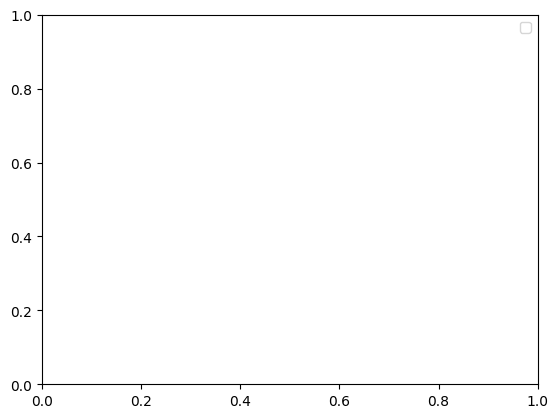

In [ ]:
key = random.PRNGKey(0)

N_KDE = 100000
N_POINTS_TRAIN = 1000000
N_POINTS_TEST = 100000
N_POINTS_EPS = 100000
N_SAMPLE = 10000
N_SAMPLES = 10


N_EPOCHS = 100
LEARNING_RATE = 0.001
PATIENCE = 7
COOLDOWN = 0
FACTOR = .5
RTOL = 1e-4  
ACCUMULATION_SIZE = 200
LEARNING_RATE_MIN = 1e-6

BATCH_SIZE = 256
NUM_BATCH = 1024
NUM_CLASSES = 2
HIDDEN_SIZE = 256
NUM_LAYERS = 7
WDECAY = .001
N_GRID_FINAL = 10000
N_GRID_EXPLO = 1000


C2ST_ABC = {}
C2ST_NN = {}
C2ST_KDE_NN = {}
C2ST_KDE_NN_EMPIRIC = {}
PARAMS = {}
TEST_ACCURACY = {}
for alpha in tqdm(ALPHAS):
    EPSILON_STAR = EPSILONS[alpha]
    print(f"----------------------\nALPHA = {alpha} EPSILON = {EPSILON_STAR:.2}\n----------------------")


    print("Simulations of the testing dataset...")
    time_sim = time.time()
    key, subkey = random.split(key)
    X_test, y_test, key = get_dataset_gauss(subkey, N_POINTS_TEST, prior_simulator, data_simulator, discrepancy, EPSILON_STAR, TRUE_DATA)
    print("Test check:", np.any(X_test[:,0]!=np.sort(X_test[:,0])))
    print('Time to simulate the testing dataset: {:.2f}s\n'.format(time.time()-time_sim))


    print("Simulations of the training dataset...")
    time_sim = time.time()
    key, subkey = random.split(key)
    X_train, y_train, key = get_dataset_gauss(subkey, N_POINTS_TRAIN, prior_simulator, data_simulator, discrepancy, EPSILON_STAR, TRUE_DATA)
    print("Train check:", np.any(X_train[:,0]!=np.sort(X_train[:,0])))
    print('Time to simulate the training dataset: {:.2f}s\n'.format(time.time()-time_sim))
    
    print("Training the neural network...")
    time_nn = time.time()
    params, train_accuracy, train_losses, test_accuracy, test_losses, key = train_loop(key, N_EPOCHS, NUM_LAYERS, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE, NUM_BATCH, LEARNING_RATE, WDECAY, PATIENCE, COOLDOWN, FACTOR, RTOL, ACCUMULATION_SIZE, LEARNING_RATE_MIN, prior_simulator, data_simulator, discrepancy, true_data = TRUE_DATA, X_train = X_train, y_train = y_train, X_test = X_test, y_test =  y_test, N_POINTS_TRAIN = N_POINTS_TRAIN, N_POINTS_TEST = N_POINTS_TEST, epsilon = EPSILON_STAR, verbose = True)
    print('Time to train the neural network: {:.2f}s\n'.format(time.time()-time_nn))

    PARAMS[alpha] = params
    TEST_ACCURACY[alpha] = test_accuracy[-1]
    
    kde_approx = lambda x: true_pseudo_post(x, np.mean(TRUE_DATA), EPSILONS[alpha], prior)
    X = np.concatenate([X_train, X_test], axis=0)
    key, subkey = random.split(key)
    kde_approx_empiric = gaussian_kde(X[random.choice(subkey, X.shape[0], (N_KDE,)),0])
    grid_kde_nn, pdf_kde_nn = find_grid_explorative(lambda x: new_post_pdf_z(params, x, TRUE_DATA, kde_approx), 10000, 10000, MINN, MAXX)
    grid_kde_nn_empiric, pdf_kde_nn_empiric = find_grid_explorative(lambda x: new_post_pdf_z(params, x, TRUE_DATA, kde_approx_empiric), 10000, 10000, MINN, MAXX)
    grid_nn, pdf_nn = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA, PRIOR_LOGPDF), 10000, 10000, MINN, MAXX)
    accuraccy_abc, accuraccy_nn, accuraccy_kde_nn, accuraccy_kde_nn_empiric = [], [], [], []
    for _ in range(N_SAMPLES):
        sample_true = true_post(TRUE_DATA).rvs(N_SAMPLE)
        key, key_abc, key_nn, key_kde_nn = random.split(key, 4)
        sample_nn = post_sample(key_nn, grid_nn, pdf_nn, N_SAMPLE)
        sample_kde_nn = post_sample(key_kde_nn, grid_kde_nn, pdf_kde_nn, N_SAMPLE)
        sample_abc = X[random.choice(key_abc, X.shape[0], (N_SAMPLE,)),0]
        sample_kde_nn_empiric = post_sample(key_kde_nn, grid_kde_nn_empiric, pdf_kde_nn_empiric, N_SAMPLE)
        if np.isnan(sample_nn).any(): accuraccy_nn.append(1)
        else: accuraccy_nn.append(np.array(c2st(torch.tensor(sample_true)[:,None], torch.tensor(sample_nn)[:,None]))[0])
        if np.isnan(sample_kde_nn).any(): accuraccy_kde_nn.append(1)
        else: accuraccy_kde_nn.append(np.array(c2st(torch.tensor(sample_true)[:,None], torch.tensor(sample_kde_nn)[:,None]))[0])
        if np.isnan(sample_abc).any(): accuraccy_abc.append(1)
        else: accuraccy_abc.append(np.array(c2st(torch.tensor(sample_true)[:,None], torch.tensor(sample_abc)[:,None]))[0])
        if np.isnan(sample_kde_nn_empiric).any(): accuraccy_kde_nn_empiric.append(1)
        else: accuraccy_kde_nn_empiric.append(np.array(c2st(torch.tensor(sample_true)[:,None], torch.tensor(sample_kde_nn_empiric)[:,None]))[0])
        
    C2ST_ABC[alpha] = np.array(accuraccy_abc)
    C2ST_NN[alpha] = np.array(accuraccy_nn)
    C2ST_KDE_NN[alpha] = np.array(accuraccy_kde_nn)
    C2ST_KDE_NN_EMPIRIC[alpha] = np.array(accuraccy_kde_nn_empiric)




In [5]:
sample_true.shape

(10000,)

# Display results


## ABC Pseudo posterior

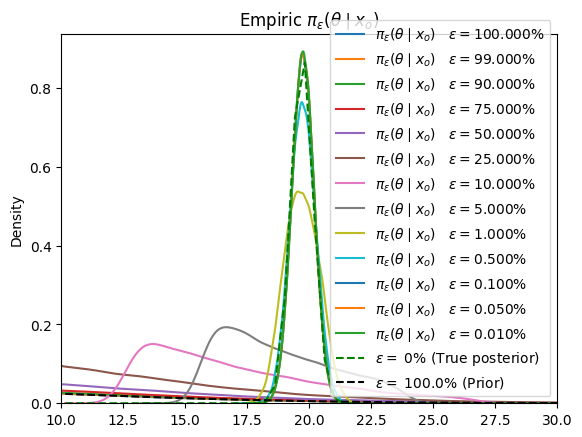

In [6]:
for alpha in ALPHAS:
    zs, mus, dists, key = ABC_gauss(key, TRUE_DATA, EPSILONS[alpha], 100000)
    label = "$\pi_\epsilon(\\theta\mid x_o) \quad \epsilon = ${:.3%}".format(alpha)
    sns.kdeplot(mus.reshape(-1), label = label)
x = np.linspace(-200, 200, 1000)
plt.plot(x, true_post(TRUE_DATA).pdf(x), label = "$\epsilon =$ 0% (True posterior)", linestyle = "--", color = "green")
plt.plot(x, stats.norm.pdf(x, loc = MU0, scale = SIGMA0), label = "$\epsilon =$ 100.0% (Prior)", linestyle = "--", color = "black")
plt.title("Empiric $\pi_\epsilon(\\theta\mid x_o)$")
plt.legend()
plt.xlim(TRUE_MU-10, TRUE_MU+10)
plt.show()

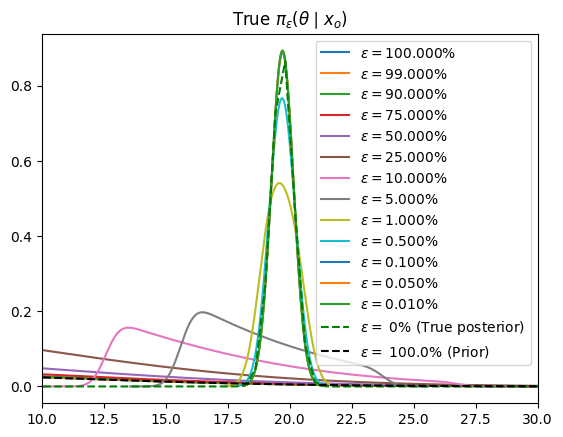

In [7]:
prior = stats.norm(loc = MU0, scale = SIGMA0)
for alpha in ALPHAS:
    EPSILON_STAR = EPSILONS[alpha]
    grid_pseudo, pdf_pseudo = find_grid_explorative(lambda x: true_pseudo_post(x, np.mean(TRUE_DATA), EPSILON_STAR, prior), 1000, 1000, MINN, MAXX)
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid_pseudo, pdf_pseudo/np.trapz(pdf_pseudo, grid_pseudo), label = label)
x = np.linspace(-200, 200, 1000)
plt.plot(x, true_post(TRUE_DATA).pdf(x), label = "$\epsilon =$ 0% (True posterior)", linestyle = "--", color = "green")
plt.plot(x, stats.norm.pdf(x, loc = MU0, scale = SIGMA0), label = "$\epsilon =$ 100.0% (Prior)", linestyle = "--", color = "black")
plt.title("True $\pi_\epsilon(\\theta\mid x_o)$")
plt.legend()
plt.xlim(TRUE_MU-10, TRUE_MU+10)
plt.show()

## ABC-NRE Approximation

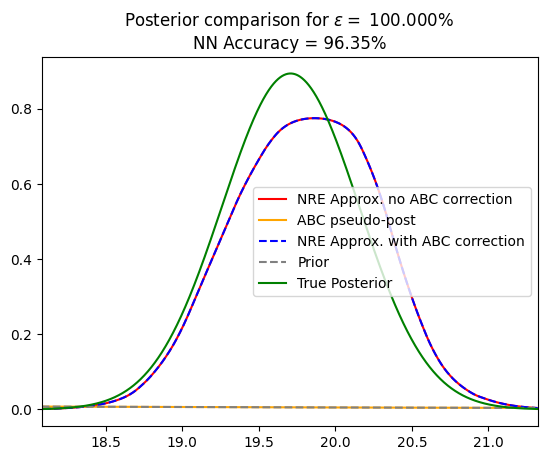

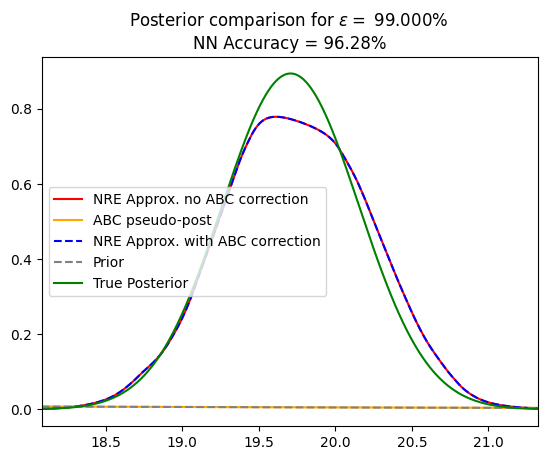

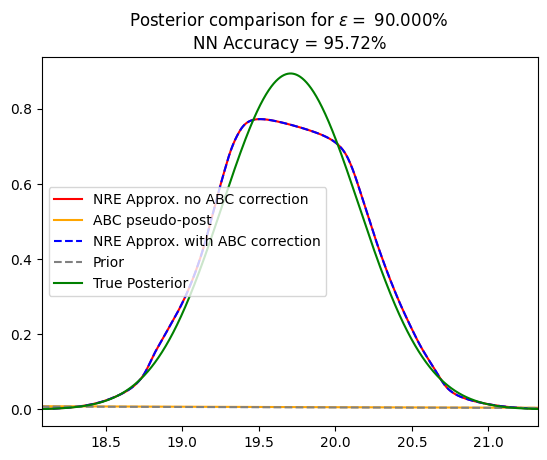

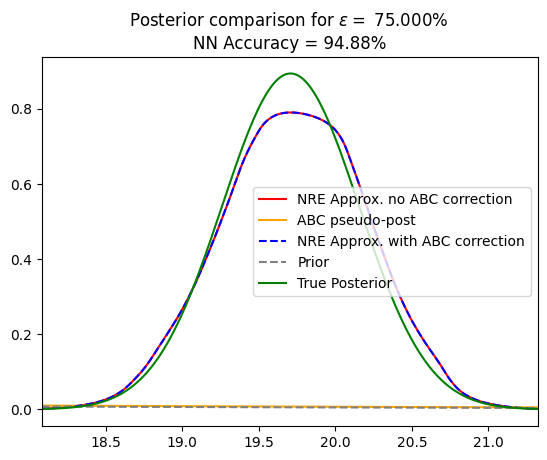

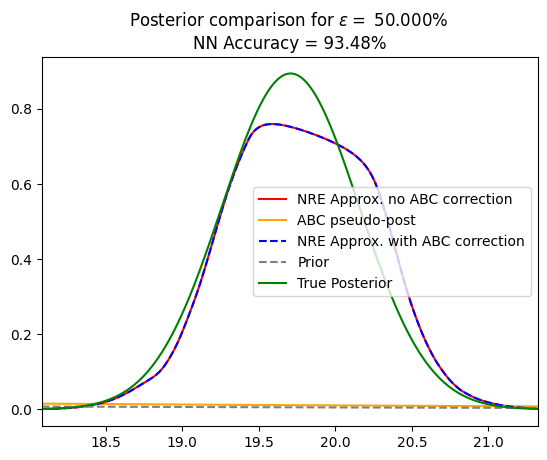

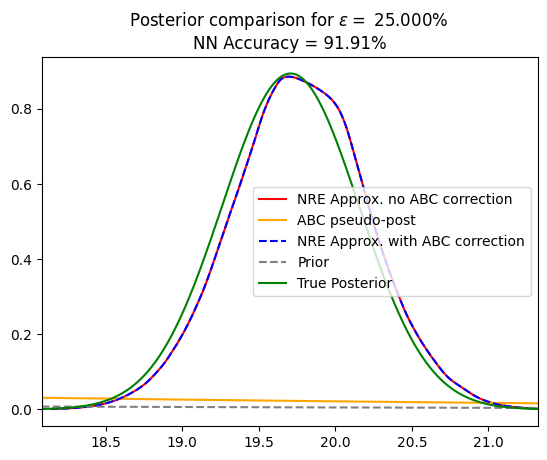

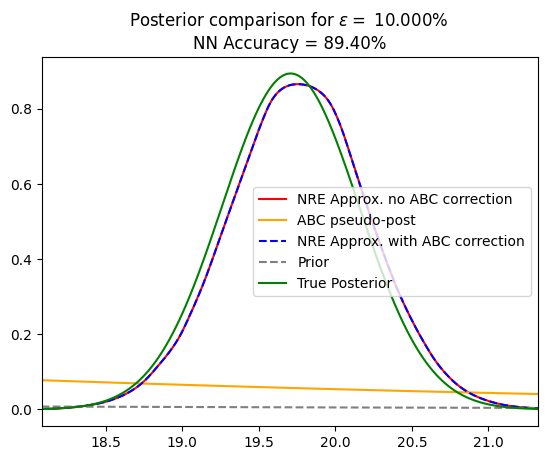

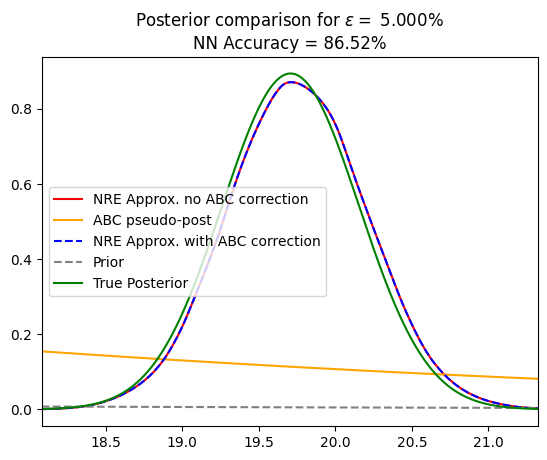

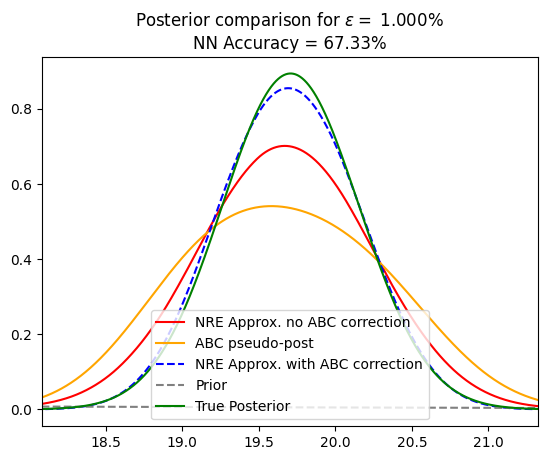

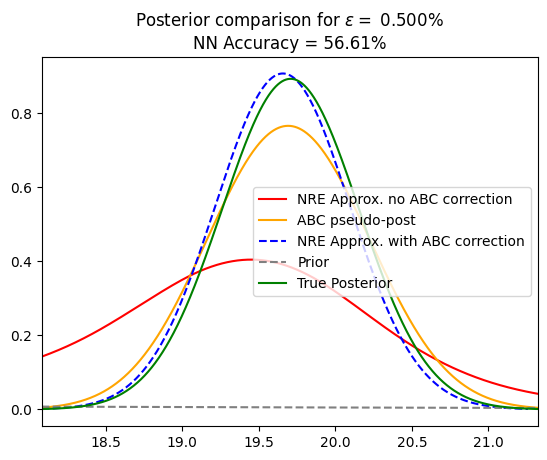

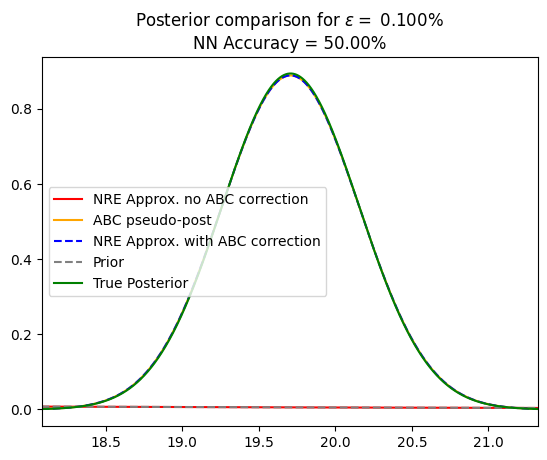

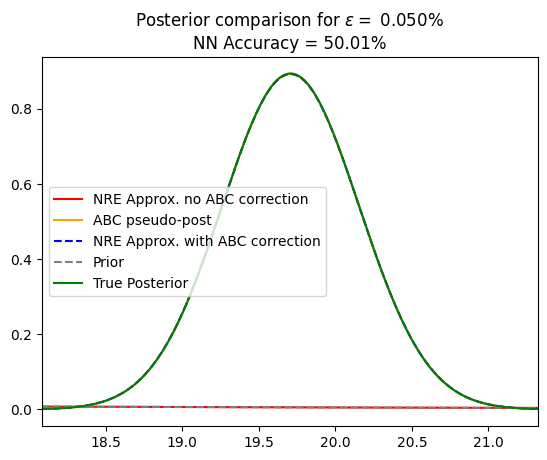

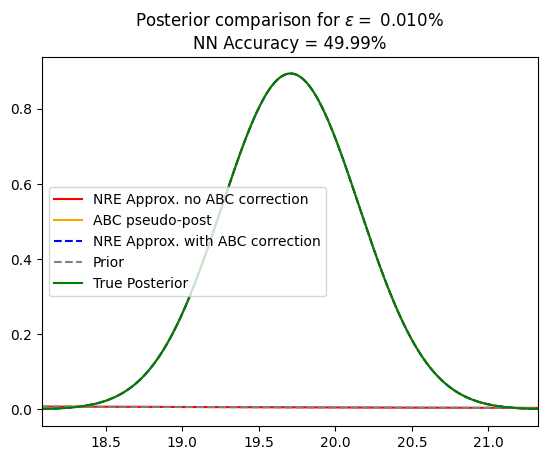

In [8]:
from jax.scipy.stats import norm, gaussian_kde
from functions.SBC import new_post_pdf_z
MINN, MAXX = -100, 100
PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)
prior_pdf = lambda x: norm.pdf(x, loc = MU0, scale = SIGMA0)
prior = stats.norm(loc = MU0, scale = SIGMA0)
posterior = true_post
likelihood = lambda x: jnp.exp(jnp.sum((x-TRUE_DATA)**2)/(2*SIGMA**2))
grid_prior, pdf_prior = find_grid_explorative(prior_pdf, 10000, 10000, MINN, MAXX)
grid_true, pdf_true = find_grid_explorative(lambda x: true_post(TRUE_DATA).pdf(x), 10000, 10000, MINN, MAXX)

Z_prior = np.trapz(pdf_prior, grid_prior)
Z_true = np.trapz(pdf_true, grid_true)

for alpha in ALPHAS:
    EPSILON_STAR = EPSILONS[alpha]
    kde_approx = lambda x: true_pseudo_post(x, np.mean(TRUE_DATA), EPSILON_STAR, prior)

    params = PARAMS[alpha] 
    grid_pseudo, pdf_pseudo = find_grid_explorative(lambda x: true_pseudo_post(x, np.mean(TRUE_DATA), EPSILON_STAR, prior), 10000, 10000, MINN, MAXX)
    grid_nn, pdf_nn = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA, PRIOR_LOGPDF), 10000, 10000, MINN, MAXX)
    grid_kde_nn, pdf_kde_nn = find_grid_explorative(lambda x: new_post_pdf_z(params, x, TRUE_DATA, kde_approx), 10000, 10000, MINN, MAXX)
    Z_pseudo = np.trapz(pdf_pseudo, grid_pseudo)
    Z_nn = np.trapz(pdf_nn, grid_nn)
    Z_kde_nn = np.trapz(pdf_kde_nn, grid_kde_nn)
    
    plt.plot(grid_nn, pdf_nn/Z_nn, label = 'NRE Approx. no ABC correction', color = "red")
    plt.plot(grid_pseudo, pdf_pseudo/Z_pseudo, label = "ABC pseudo-post", color = "orange")

    plt.plot(grid_kde_nn, pdf_kde_nn/Z_kde_nn, label = "NRE Approx. with ABC correction", color = "blue", linestyle = "--")
    plt.plot(grid_prior, pdf_prior/Z_prior, label = 'Prior', color = "grey", linestyle = "--")
    plt.plot(grid_true, pdf_true/Z_true, label = 'True Posterior', color = "green")





    plt.xlim(np.min(grid_true), np.max(grid_true))
    plt.title(f"Posterior comparison for $\epsilon =$ {alpha:.3%} \nNN Accuracy = {TEST_ACCURACY[alpha]:.2%}")
    plt.legend()
    plt.show()


## Decision function

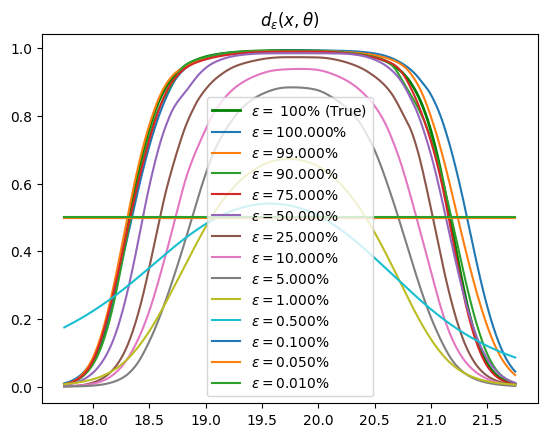

In [9]:
grid = np.linspace(np.mean(TRUE_DATA)-2, np.mean(TRUE_DATA)+2, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
plt.plot(grid, true_decision, color = "green", label = "$\epsilon =$ 100% (True)", lw = 2)
for alpha in ALPHAS:
    params = PARAMS[alpha]
    epsilon = EPSILONS[alpha]
    approx_decision = 1/(1+jnp.exp(-logratio_batch_z(params, grid, TRUE_DATA)))
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid, approx_decision, label = label)
plt.legend()
plt.title("$d_\epsilon(x,\\theta)$")
plt.show()



## Likelihood-to-evidence ratio

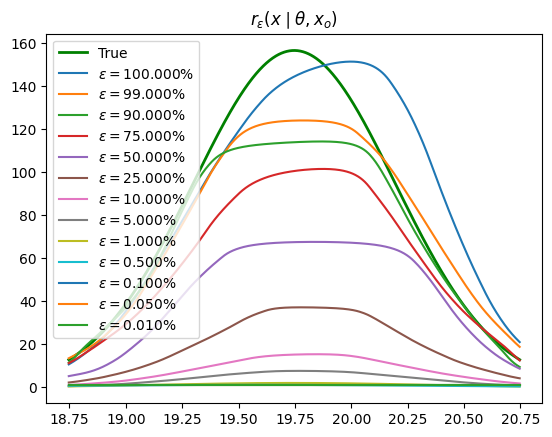

In [10]:
grid = np.linspace(np.mean(TRUE_DATA)-1, np.mean(TRUE_DATA)+1, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
true_ratio = true_decision/(1-true_decision)
plt.plot(grid, true_ratio, color = "green", label = "True", lw = 2)
for alpha in ALPHAS:
    params = PARAMS[alpha]
    epsilon = EPSILONS[alpha]
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA))
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid, approx_ratio, label = label)
plt.legend()
plt.title("$r_\epsilon(x\mid \\theta, x_o)$")
plt.show()



## ABC-NRE approximation without correction and normalization

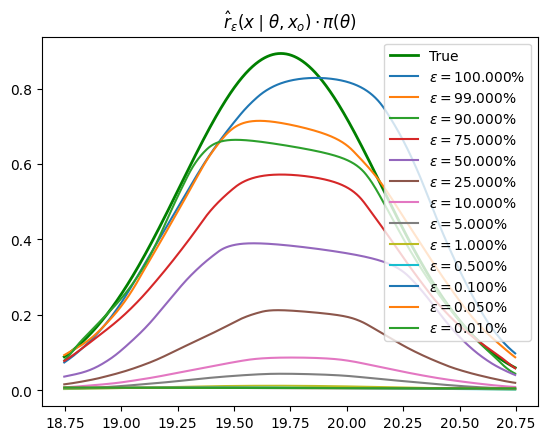

In [11]:
grid = np.linspace(np.mean(TRUE_DATA)-1, np.mean(TRUE_DATA)+1, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
true_ratio = true_decision/(1-true_decision)
plt.plot(grid, true_ratio*prior.pdf(grid), color = "green", label = "True", lw = 2)
for alpha in ALPHAS:
    params = PARAMS[alpha]
    epsilon = EPSILONS[alpha]
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA))
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid, approx_ratio*prior.pdf(grid), label = label)
plt.legend()
plt.title("$\hat r_\epsilon(x\mid\\theta, x_o)\cdot \pi(\\theta)$")
plt.show()

## ABC-NRE approximation without correction but with normalization

Z_true = 0.974229990357939
Z_approx (for epsilon = inf) = 1.0
Z_approx (for epsilon = 1.8e+03) = 0.89
Z_approx (for epsilon = 1.1e+03) = 0.84
Z_approx (for epsilon = 7e+02) = 0.7
Z_approx (for epsilon = 3.9e+02) = 0.5
Z_approx (for epsilon = 1.7e+02) = 0.23
Z_approx (for epsilon = 5.1e+01) = 0.097
Z_approx (for epsilon = 1.7e+01) = 0.049
Z_approx (for epsilon = 0.79) = 0.015
Z_approx (for epsilon = 0.2) = 0.011
Z_approx (for epsilon = 0.0071) = 0.011
Z_approx (for epsilon = 0.0019) = 0.011
Z_approx (for epsilon = 7.6e-05) = 0.011


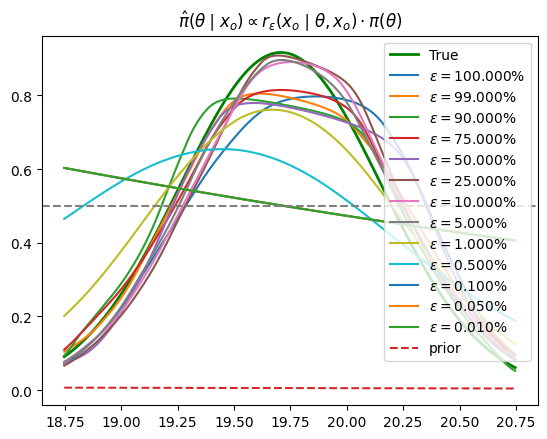

In [12]:
grid = np.linspace(np.mean(TRUE_DATA)-1, np.mean(TRUE_DATA)+1, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
true_ratio = true_decision/(1-true_decision)
true_postt = true_ratio*prior.pdf(grid)
Z_true = np.trapz(true_postt, grid)
print('Z_true =', Z_true)
plt.plot(grid,true_postt/Z_true , color = "green", label = "True", lw = 2)
for alpha in ALPHAS:
    params = PARAMS[alpha]
    epsilon = EPSILONS[alpha]
    
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA))
    pseudo = prior.pdf(grid)
    approx = approx_ratio*pseudo
    Z_approx = np.trapz(approx, grid)
    print(f"Z_approx (for epsilon = {epsilon:.2}) = {Z_approx:.2}")
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid,approx/Z_approx, label = label)
plt.plot(grid, prior.pdf(grid), label ="prior", linestyle = "--")
plt.legend()
plt.title("$\hat \pi(\\theta \mid x_o) \propto r_\epsilon(x_o\mid\\theta, x_o)\cdot \pi(\\theta)$")
plt.axhline(0.5, color = "grey", linestyle = "--")
plt.show()

## ABC-NRE approximation with correction but no normalization

/var/folders/bc/mlt2yzpn2hsg7qskk5s47jy40000gn/T/ipykernel_92108/1812100366.py:11: RuntimeWarning: divide by zero encountered in divide
  return 1/(1+1/true_ratio_z(mus, z, prior, posterior))
/var/folders/bc/mlt2yzpn2hsg7qskk5s47jy40000gn/T/ipykernel_92108/1812100366.py:11: RuntimeWarning: overflow encountered in divide
  return 1/(1+1/true_ratio_z(mus, z, prior, posterior))


(18.08180809020996, 21.32213020324707)

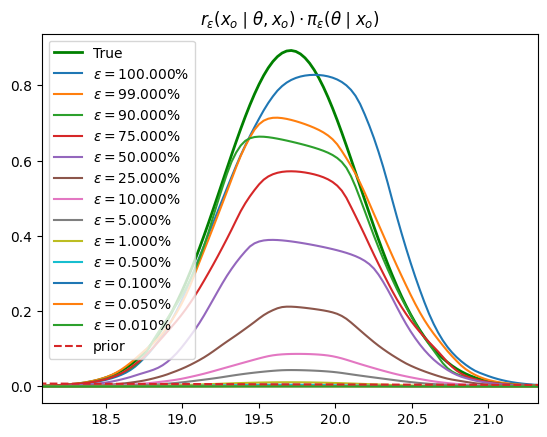

In [13]:
grid = np.linspace(-100, 200, 10000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
true_ratio = true_decision/(1-true_decision)
true_postt = true_ratio*prior.pdf(grid)
plt.plot(grid,true_postt , color = "green", label = "True", lw = 2)
for alpha in ALPHAS:
    params = PARAMS[alpha]
    epsilon = EPSILONS[alpha]
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA))
    pseudo = true_pseudo_post(grid, jnp.mean(TRUE_DATA),epsilon, prior)
    approx = approx_ratio*pseudo#/np.trapz(pseudo, grid)
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid,approx, label = label)
plt.plot(grid, prior.pdf(grid), label ="prior", linestyle = "--")

plt.legend()
plt.title("$r_\epsilon(x_o\mid\\theta, x_o)\cdot \pi_\epsilon(\\theta\mid x_o)$")
plt.xlim(grid_true.min(), grid_true.max())

## ABC-NRE approximation with correction and normalization

Z_true = 0.974229990357939
Z_approx (for epsilon = inf) = 1.0
Z_approx (for epsilon = 1.8e+03) = 0.89
Z_approx (for epsilon = 1.1e+03) = 0.84
Z_approx (for epsilon = 7e+02) = 0.7
Z_approx (for epsilon = 3.9e+02) = 0.5
Z_approx (for epsilon = 1.7e+02) = 0.23
Z_approx (for epsilon = 5.1e+01) = 0.097
Z_approx (for epsilon = 1.7e+01) = 0.049
Z_approx (for epsilon = 0.79) = 0.013
Z_approx (for epsilon = 0.2) = 0.0049
Z_approx (for epsilon = 0.0071) = 0.00093
Z_approx (for epsilon = 0.0019) = 0.00048
Z_approx (for epsilon = 7.6e-05) = 9.7e-05


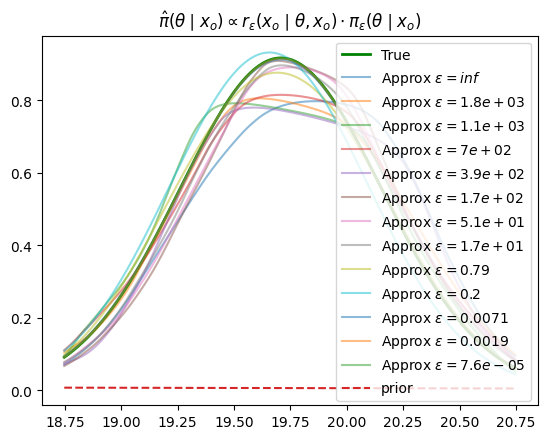

In [15]:
grid = np.linspace(np.mean(TRUE_DATA)-1, np.mean(TRUE_DATA)+1, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
true_ratio = true_decision/(1-true_decision)
true_postt = true_ratio*prior.pdf(grid)
Z_true = np.trapz(true_postt, grid)
print('Z_true =', Z_true)
plt.plot(grid,true_postt/Z_true , color = "green", label = "True", lw = 2)
for alpha in ALPHAS:
    params = PARAMS[alpha]
    epsilon = EPSILONS[alpha]
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA))
    pseudo = true_pseudo_post(grid, jnp.mean(TRUE_DATA),epsilon, prior)
    approx = approx_ratio*pseudo
    Z_approx = np.trapz(approx, grid)
    print(f"Z_approx (for epsilon = {epsilon:.2}) = {Z_approx:.2}")
    plt.plot(grid,approx/Z_approx, label = f"Approx $\epsilon = {epsilon:.2}$", alpha = .5)
plt.plot(grid, prior.pdf(grid), label ="prior", linestyle = "--")
plt.legend()
plt.title("$\hat \pi(\\theta \mid x_o) \propto r_\epsilon(x_o\mid \\theta, x_o)\cdot \pi_\epsilon(\\theta\mid x_o)$")
plt.show()

# Classifier 2 Samples Test (C2ST)

In [ ]:
# C2ST_ABC = {}
# C2ST_NN = {}
# C2ST_KDE_NN = {}

# N_sample = 1000
# N_samples = 2
# grid_true, pdf_true = find_grid_explorative(lambda x: true_post(TRUE_DATA).pdf(x), 1000, 1000, MINN, MAXX)
# sample_true = true_post(TRUE_DATA).rvs(N_sample)
# key = random.PRNGKey(10)

# for alpha in tqdm(np.sort(list(EPSILONS.keys()))[::-1]):
#     params = PARAMS[alpha]
#     c_alpha = []
#     kde_approx = lambda x: true_pseudo_post(x, np.mean(TRUE_DATA), EPSILONS[alpha], prior)
#     grid_kde_nn, pdf_kde_nn = find_grid_explorative(lambda x: new_post_pdf_z(params, x, TRUE_DATA, kde_approx), 10000, 10000, MINN, MAXX)
#     grid_nn, pdf_nn = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA, PRIOR_LOGPDF), 10000, 10000, MINN, MAXX)
#     accuraccy_abc, accuraccy_nn, accuraccy_kde_nn = [], [], []
#     for _ in range(N_samples):
#         sample_true = true_post(TRUE_DATA).rvs(N_sample)
#         key, key_abc, key_nn, key_kde_nn = random.split(key, 4)
#         sample_nn = post_sample(key_nn, grid_nn, pdf_nn, N_sample)
#         sample_kde_nn = post_sample(key_kde_nn, grid_kde_nn, pdf_kde_nn, N_sample)
#         sample_abc = ABC_gauss(key_abc, TRUE_DATA, EPSILONS[alpha], N_sample)[1]
#         if np.isnan(sample_nn).any(): accuraccy_nn.append(1)
#         else: accuraccy_nn.append(np.array(c2st(torch.tensor(sample_true)[:,None], torch.tensor(sample_nn)[:,None]))[0])
#         if np.isnan(sample_kde_nn).any(): accuraccy_kde_nn.append(1)
#         else: accuraccy_kde_nn.append(np.array(c2st(torch.tensor(sample_true)[:,None], torch.tensor(sample_kde_nn)[:,None]))[0])
#         if np.isnan(sample_abc).any(): accuraccy_abc.append(1)
#         else: accuraccy_abc.append(np.array(c2st(torch.tensor(sample_true)[:,None], torch.tensor(sample_abc)))[0])
#     C2ST_ABC[alpha] = np.array(accuraccy_abc)
#     C2ST_NN[alpha] = np.array(accuraccy_nn)
#     C2ST_KDE_NN[alpha] = np.array(accuraccy_kde_nn)
                         
        

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
ALPHAS = ALPHAS[:-1]

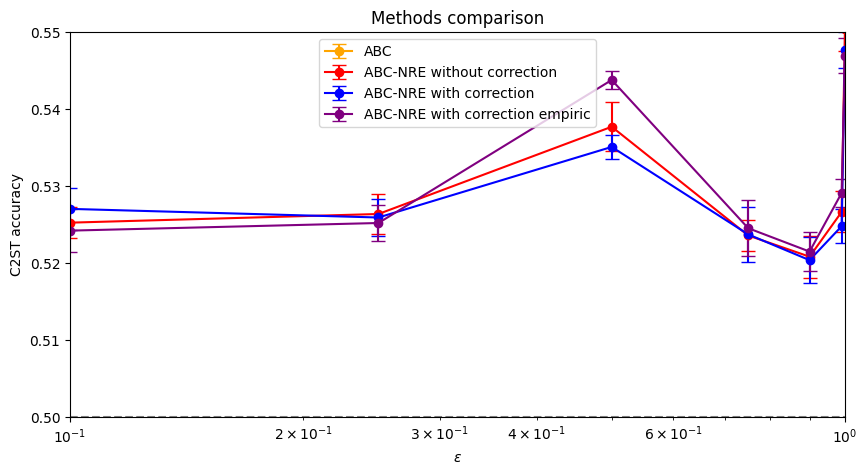

In [ ]:
mean_abc = np.array([C2ST_ABC[alpha].mean() for alpha in ALPHAS])
std_abc = np.array([C2ST_ABC[alpha].std() for alpha in ALPHAS])
conf_interval_abc = 1.96*std_abc/np.sqrt(N_SAMPLES)

mean_nn = np.array([C2ST_NN[alpha].mean() for alpha in ALPHAS])
std_nn = np.array([C2ST_NN[alpha].std() for alpha in ALPHAS])
conf_interval_nn = 1.96*std_nn/np.sqrt(N_SAMPLES)

mean_kde_nn = np.array([C2ST_KDE_NN[alpha].mean() for alpha in ALPHAS])
std_kde_nn = np.array([C2ST_KDE_NN[alpha].std() for alpha in ALPHAS])
conf_interval_kde_nn = 1.96*std_kde_nn/np.sqrt(N_SAMPLES)

mean_kde_nn_empiric = np.array([C2ST_KDE_NN_EMPIRIC[alpha].mean() for alpha in ALPHAS])
std_kde_nn_empiric = np.array([C2ST_KDE_NN_EMPIRIC[alpha].std() for alpha in ALPHAS])
conf_interval_kde_nn_empiric = 1.96*std_kde_nn_empiric/np.sqrt(N_SAMPLES)

f, ax = plt.subplots(1, 1, figsize = (10, 5))
plt.errorbar(ALPHAS, mean_abc, yerr = conf_interval_abc, label = "ABC", color = "orange", fmt='o-', capsize=5)
plt.errorbar(ALPHAS, mean_nn, yerr = conf_interval_nn, label = "ABC-NRE without correction", color = "red", fmt='o-', capsize=5)
plt.errorbar(ALPHAS, mean_kde_nn, yerr = conf_interval_kde_nn, label = "ABC-NRE with correction", color = "blue", fmt='o-', capsize=5)
plt.errorbar(ALPHAS, mean_kde_nn_empiric, yerr = conf_interval_kde_nn_empiric, label = "ABC-NRE with correction empiric", color = "purple", fmt='o-', capsize=5)

plt.title("Methods comparison")
plt.xlabel("$\epsilon$")
plt.gca().invert_xaxis()
plt.xscale("log")
plt.ylabel("C2ST accuracy")
plt.axhline(.5, color = "grey", linestyle = "--")
plt.legend(loc = "upper center")
plt.show()